In [232]:
!pip install python-dotenv
!pip install rasterio

In [260]:
from dotenv import load_dotenv
import os
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# Load environment variables from .env file
load_dotenv()

# Retrieve the client credentials from environment variables
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')

# Ensure that client_id and client_secret are loaded correctly
if not client_id or not client_secret:
    raise ValueError("Missing client_id or client_secret in the .env file.")

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(
    token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
    client_secret=client_secret,
    include_client_id=True
)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances")

# Print the response content (you can change this to JSON or any other format as needed)
print(resp.content)

b'[]'


In [237]:
def sentinelhub_compliance_hook(response):
    response.raise_for_status()
    return response

oauth.register_compliance_hook("access_token_response", sentinelhub_compliance_hook)

In [238]:
URL = "https://sh.dataspace.copernicus.eu/api/v1/process"

In [258]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

def download_image_sentinel(request, output_path="zone.png"):
  response = oauth.post(URL, json=request)
  show_tiff_4channels(response)

  if response.status_code == 200:
      with open(f"{output_path}", "wb") as file:
          file.write(response.content)
      print(f"Image saved as {output_path}")
  else:
      print(f"Error: {response.status_code} - {response.text}")


# Coords converter

In [ ]:
from pyproj import Transformer


def to_coords(bbox):
  transformer = Transformer.from_crs('epsg:32633', 'epsg:4326', always_xy=True)

  lon_min, lat_min = transformer.transform(bbox[0], bbox[1])
  lon_max, lat_max = transformer.transform(bbox[2], bbox[3])

  print(f"Bounding box in geographic coordinates (Lon, Lat):")
  print(f"Bottom-left: ({lon_min}, {lat_min})")
  print(f"Top-right: ({lon_max}, {lat_max})")

  return lon_min, lat_min, lon_max, lat_max

to_coords([444170, 4574059, 557052, 4767386])

Bounding box in geographic coordinates (Lon, Lat):
Bottom-left: (14.332964874231491, 41.316066753848936)
Top-right: (15.700599896404853, 43.05702946199435)


(14.332964874231491, 41.316066753848936, 15.700599896404853, 43.05702946199435)

In [ ]:
def from_coords(bbox):
  transformer = Transformer.from_crs('epsg:4326', 'epsg:32633', always_xy=True)

  x_min, y_min = transformer.transform(bbox[0], bbox[1])
  x_max, y_max = transformer.transform(bbox[2], bbox[3])

  print(f"Converted bounding box in projected coordinates (X, Y):")
  print(f"Bottom-left: ({x_min}, {y_min})")
  print(f"Top-right: ({x_max}, {y_max})")

  return x_min, y_min, x_max, y_max

from_coords([14.332964874231491, 41.316066753848936, 15.700599896404853, 43.05702946199435])

Converted bounding box in projected coordinates (X, Y):
Bottom-left: (444170.0000000001, 4574058.999999999)
Top-right: (557052.0000000001, 4767386.0)


(444170.0000000001, 4574058.999999999, 557052.0000000001, 4767386.0)

# Sentinel2

In [252]:
def prepare_req_s2(bbox=[
                13.822174072265625,
                45.85080395917834,
                14.55963134765625,
                46.29191774991382,
            ],
                    time={
                        "from": "2020-06-20T00:00:00Z",
                        "to": "2020-06-20T23:59:59Z",
                    }):

  evalscript = """
  //VERSION=3
  function setup() {
    return {
      input: ["B02", "B03", "B04"],
      output: { bands: 3 },
    }
  }

  function evaluatePixel(sample) {
    return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02]
  }
  """

  request = {
      "input": {
          "bounds": {
              "properties": {"crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"},
              "bbox": bbox,
          },
          "data": [
              {
                  "type": "sentinel-2-l2a",
                  "dataFilter": {
                      "timeRange": time,
                  },
              }
          ],
      },
      "output": {
          "width": 512,
          "height": 512,
      },
      "evalscript": evalscript,
  }

  return request

In [261]:
download_image_sentinel(prepare_req_s2([25.934601, 40.850177, 26.109009, 40.945158],
                                       {
                        "from": "2023-08-20T00:00:00Z",
                        "to": "2023-08-20T23:59:59Z",
                    }), "s2greece.tiff")

IndexError: index 3 is out of bounds for axis 2 with size 3

# Sentinel2 swir

In [262]:
def prepare_req_s2_swir(bbox=[
                13.822174072265625,
                45.85080395917834,
                14.55963134765625,
                46.29191774991382,
            ],
                    time={
                        "from": "2020-06-20T00:00:00Z",
                        "to": "2020-06-20T23:59:59Z",
                    }):

  evalscript = """
  //VERSION=3
  function setup() {
    return {
      input: ["B12","B8A","B04", "dataMask"],
      output: { bands: 4 },
    }
  }

  function evaluatePixel(sample) {
    return [2.5 * sample.B12,2.5 * sample.B8A,2.5 * sample.B04, sample.dataMask ]
  }
  """

  request = {
      "input": {
          "bounds": {
              "properties": {"crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"},
              "bbox": bbox,
          },
          "data": [
              {
                  "type": "sentinel-2-l2a",
                  "dataFilter": {
                      "timeRange": time,
                  },
              }
          ],
      },
      "output": {
          "width": 512,
          "height": 512,
      },
      "evalscript": evalscript,
  }

  return request

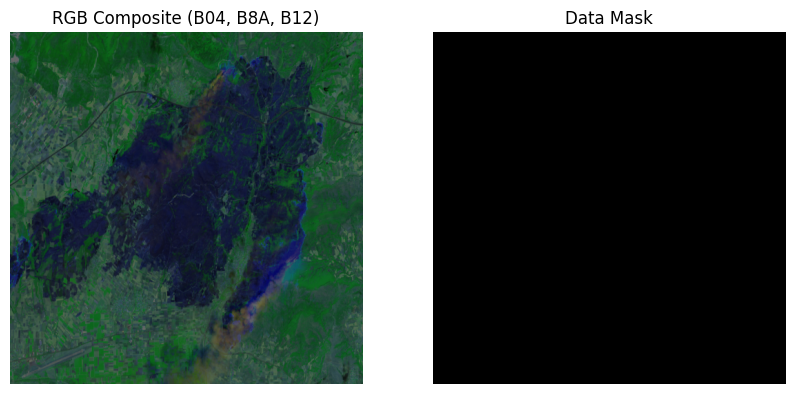

Image saved as s2greece.tiff


In [264]:
download_image_sentinel(prepare_req_s2_swir([25.934601, 40.850177, 26.109009, 40.945158],
                                       {
                        "from": "2023-08-20T00:00:00Z",
                        "to": "2023-08-20T23:59:59Z",
                    }), "s2greece.tiff")

# Sentinel3 OLCI WATER

In [ ]:
def prepare_req_water(bbox=[
                444170,
                4574059,
                557052,
                4767386,
            ],
                    time={
                        "from": "2020-06-20T00:00:00Z",
                        "to": "2020-06-20T23:59:59Z",
                    }):

  evalscript = """
  //VERSION=3
  function setup() {
    return {
      input: [
        {
          bands: ["IWV"],
          units: "REFLECTANCE", // default value
        },
      ],
      output: {
        bands: 1,
        sampleType: "UINT16", //floating point values are automatically rounded to the nearest integer by the service.
      },
    }
  }

  function evaluatePixel(sample) {
    // Return reflectance multiplied by 10000 as integers to save processing units.
    // To obtain reflectance values, simply divide the result pixel values by 10000.
    return [10000 * sample.B08, 10000 * sample.B06, 10000 * sample.B04]
  }
  """

  request = {
      "input": {
          "bounds": {
              "properties": {"crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"},
              "bbox": bbox,
          },
          "data": [
              {
                  "type": "sentinel-3-olci",
                  "dataFilter": {
                      "timeRange": time,
                  },
              }
          ],
      },
      "output": {
          "width": 512,
          "height": 512,
          "responses": [{"format": {"type": "image/tiff"}}],
      },
      "evalscript": evalscript,
  }

  return request

In [ ]:
download_image_sentinel(prepare_req_water(), "water.tiff")

Error: 400 - {"error":{"status":400,"reason":"Bad Request","message":"Collection 'S3OLCI' has no band 'IWV'.","code":"RENDERER_EXCEPTION"}}


# Sentinel3 TIR

In [ ]:
def prepare_req_tir(bbox=[
                444170,
                4574059,
                557052,
                4767386,
            ],
                    time={
                        "from": "2020-06-20T00:00:00Z",
                        "to": "2020-06-20T23:59:59Z",
                    }):
  evalscript = """
  //VERSION=3
  function setup() {
    return {
      input: [
        {
          bands: ["S7", "S8", "S9", "F1", "F2"],
        },
      ],
      output: {
        bands: 5,
        sampleType: "UINT16",
      },
    }
  }

  function multiplyband(sample) {
    // Multiply by 100
    return 100 * sample
  }

  function evaluatePixel(sample) {
    // Return the bands multiplied by 100 as integers to save processing units.
    // To obtain reflectance or BT values, simply divide the resulting pixel values by 100.
    return [
      multiplyband(sample.S7),
      multiplyband(sample.S8),
      multiplyband(sample.S9),
      multiplyband(sample.F1),
      multiplyband(sample.F2),
    ]
  }
  """

  request = {
      "input": {
          "bounds": {
              "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/32632"},
              "bbox": bbox,
          },
          "data": [
              {
                  "type": "sentinel-3-slstr",
                  "dataFilter": {
                      "timeRange": time,
                      "orbitDirection": "DESCENDING",
                  },
              }
          ],
      },
      "output": {
          "resx": 500,
          "resy": 500,
          "responses": [{"format": {"type": "image/tiff"}}],
      },
      "evalscript": evalscript,
  }

  return request

In [ ]:
download_image_sentinel(prepare_req_tir(), "tir.tiff")

Image saved as tir2.tiff


# Sentinel 3 SWIR

In [ ]:
def prepare_req_swir(bbox=[
                444170,
                4574059,
                557052,
                4767386,
            ],
                    time={
                        "from": "2020-06-20T00:00:00Z",
                        "to": "2020-06-20T23:59:59Z",
                    }):
  evalscript = """
  //VERSION=3
  function setup() {
    return {
      input: [
        {
          bands: ["S1", "S2", "S3", "S4", "S5", "S6"],
          units: "REFLECTANCE",
        },
      ],
      output: {
        bands: 6,
        sampleType: "UINT16", //floating point values are automatically rounded to the nearest integer by the service.
      },
    }
  }

  function evaluatePixel(sample) {
    // Return reflectance multiplied by 10000 as integers to save processing units.
    // To obtain reflectance or BT values, simply divide the resulting pixel values by 10000.
    return [
      10000 * sample.S1,
      10000 * sample.S2,
      10000 * sample.S3,
      10000 * sample.S4,
      10000 * sample.S5,
      10000 * sample.S6,
    ]
  }
  """

  request = {
      "input": {
          "bounds": {
              "properties": {"crs": "http://www.opengis.net/def/crs/EPSG/0/32632"},
              "bbox": bbox,
          },
          "data": [
              {
                  "type": "sentinel-3-slstr",
                  "dataFilter": {
                      "timeRange": time,
                      "orbitDirection": "DESCENDING",
                  },
              }
          ],
      },
      "output": {
          "resx": 500,
          "resy": 500,
          "responses": [{"format": {"type": "image/tiff"}}],
      },
      "evalscript": evalscript,
  }

  return request

In [ ]:
download_image_sentinel(prepare_req_swir(), "swir.tiff")

Image saved as swir.tiff


# Process tiff

In [ ]:
import rasterio
import matplotlib.pyplot as plt

In [256]:
def show_tiff(response):
    img = Image.open(io.BytesIO(response.content))
    img_array = np.array(img)

    # Show the image using matplotlib
    plt.imshow(img_array)
    plt.title("True Color Composite (B04, B03, B02)")
    plt.axis("off")
    plt.show()


def show_tiff_4channels(response):
    img = Image.open(io.BytesIO(response.content))
    img_array = np.array(img)

    # Extract bands: B12, B8A, B04, dataMask
    band_b12 = img_array[..., 0]  # Band 1 (B12)
    band_b8a = img_array[..., 1]  # Band 2 (B8A)
    band_b04 = img_array[..., 2]  # Band 3 (B04)
    data_mask = img_array[..., 3]  # Band 4 (dataMask)

    # Create RGB composite using B12 (blue), B8A (green), B04 (red)
    rgb_composite = np.dstack((band_b04, band_b8a, band_b12))

    # Normalize the bands for visualization
    rgb_composite = np.clip(rgb_composite / 2.5, 0, 255).astype(np.uint8)

    # Plot RGB composite
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_composite)
    plt.title("RGB Composite (B04, B8A, B12)")
    plt.axis("off")

    # Plot data mask
    plt.subplot(1, 2, 2)
    plt.imshow(data_mask, cmap="gray")
    plt.title("Data Mask")
    plt.axis("off")

    plt.show()


def process_tiff(file, band=1):
  # Open the GeoTIFF file
  with rasterio.open(file) as dataset:
      # Read the data from the first band (you can adjust this if your image has more bands)
      band1 = dataset.read(band)  # Reads the first band (1-indexed)

      # Print the shape of the data (height x width of the raster)
      print("Shape of the data:", band1.shape)

      # Print some basic information about the dataset
      print("CRS:", dataset.crs)
      print("Bounds:", dataset.bounds)
      print("Width:", dataset.width)
      print("Height:", dataset.height)

      # Print the first 10 pixel values from band 1
      print("First 10 pixel values from band 1:", band1.flatten()[:10])
      plt.imshow(band1, cmap='gray')
      plt.colorbar()  # Show a color scale
      plt.title('Band 1 - GeoTIFF Image')
      plt.show()

In [257]:
show_tiff_4channels(response)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7b206591a4d0>

# TEST DATA

In [ ]:
NYSA_COORDS =  [16.1411, 49.4028, 17.8353, 50.7760]
NYSA_DATE = {"from": "2024-09-08T00:00:00Z",
              "to": "2024-09-08T23:59:59Z"}
# [14.332964874231491, 41.316066753848936, 15.700599896404853, 43.05702946199435]
FIRE_COORDS = [25.941467, 39.835632, 27.408322, 41.353974]
FIRE_DATE = {"from": "2024-08-23T00:00:00Z",
              "to": "2024-08-23T23:59:59Z"}

SPLIT_FIRE = []

In [ ]:
download_image_sentinel3(prepare_req_tir(from_coords(FIRE_COORDS), FIRE_DATE), "fire.tiff")
process_tiff("fire.tiff", 4)

Converted bounding box in projected coordinates (X, Y):
Bottom-left: (1437203.232841546, 4467223.295558338)
Top-right: (1538951.205006186, 4653010.776180074)


TokenExpiredError: (token_expired) 

In [ ]:
download_image_sentinel3(prepare_req_tir(from_coords(NYSA_COORDS), NYSA_DATE), "nysa.tiff")

Converted bounding box in projected coordinates (X, Y):
Bottom-left: (582786.9908189094, 5472860.716614486)
Top-right: (699892.0010140771, 5628748.59318906)
Image saved as nysa.tiff


Shape of the data: (387, 226)
CRS: EPSG:32632
Bounds: BoundingBox(left=444170.0, bottom=4574059.0, right=557052.0, top=4767386.0)
Width: 226
Height: 387
First 10 pixel values from band 1: [29141 29288 29288 29609 29609 29886 29886 30094 30094 29164]


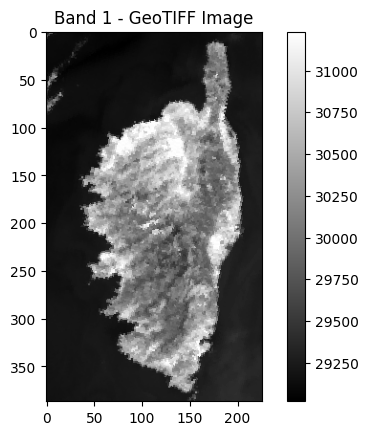

In [ ]:
process_tiff("tir.tiff")

Shape of the data: (312, 234)
CRS: EPSG:32632
Bounds: BoundingBox(left=582786.9908189094, bottom=5472860.716614486, right=699892.0010140771, top=5628748.59318906)
Width: 234
Height: 312
First 10 pixel values from band 1: [30636 30396 30396 30374 30465 30481 30481 30426 30426 30484]


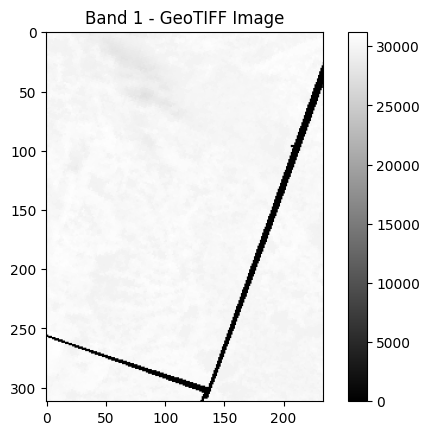

In [ ]:
process_tiff("nysa.tiff")